In [1]:
GPU = True  #set to True to use GPU for XGboost 
OPTUNA = False #set to True to run Optuna first, false to use saved hyperparameters

## XGBoost Model Testing

In [2]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 500)

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest, mutual_info_classif

import xgboost as xgb
print('XGB version:', xgb.__version__)

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

import neptune.new as neptune
from neptune.new.integrations.xgboost import NeptuneCallback
import neptune.new.integrations.optuna as optuna_utils
from neptune.new.types import File

from tqdm import tqdm

import shap

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from common_functions import plot_confusion_matrix

from pathlib import Path  #for Windows/Linux compatibility
DATAPATH = Path(r'data')

import warnings
warnings.simplefilter('ignore')


XGB version: 1.6.2


In [3]:
train = pd.read_csv(DATAPATH / "train_selected.csv")
#test = pd.read_csv(DATAPATH / "test.csv")

**Setup Neptuna.ai experiment tracking**

In [4]:
run = neptune.init(
    project="cmunch1/nba-prediction",
    source_files=['07a_xgb_model_test.ipynb']
)

https://app.neptune.ai/cmunch1/nba-prediction/e/XGB-2
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


**Logging Note**

In [5]:
run["note"] = "Initial Run w/ saved"

**Options**

In [6]:
run["model/parameters/GPU"] = GPU
run["model/parameters/OPTUNA"] = OPTUNA
if OPTUNA:
    run["model/parameters/optuna_folds"] = OPTUNA_FOLDS = 5
    run["model/parameters/optuna_trials"] = OPTUNA_TRIALS = 50

run["model/parameters/k_folds"] = K_FOLDS = 5
run["model/parameters/seed"] = SEED = 13
run["model/parameters/num_boost_round"] = NUM_BOOST_ROUND = 700
run["model/parameters/enable_categorical"] = ENABLE_CATEGORICAL = True

VERBOSITY = 0


**Fix Datatypes for smaller memory footprint**

In [7]:
def fix_datatypes(df):
    df['GAME_DATE_EST'] = pd.to_datetime(df['GAME_DATE_EST'])

    long_integer_fields = ['GAME_ID', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'SEASON']

    #convert long integer fields to int32 from int64
    for field in long_integer_fields:
        df[field] = df[field].astype('int32')
    
    #convert the remaining int64s to int8
    for field in df.select_dtypes(include=['int64']).columns.tolist():
        df[field] = df[field].astype('int8')
        
    #convert float64s to float16s
    for field in df.select_dtypes(include=['float64']).columns.tolist():
        df[field] = df[field].astype('float16')
        
    return df

train = fix_datatypes(train)
#test = fix_datatypes(test)


**Encode categoricals**

In [8]:
# To use special category feature capabalities in XGB and LGB, categoricals must be ints from 0 to N-1
# Conversion can be accomplished by simple subtraction for several features
# (these capabilities may or may not be used, but encoding does not hurt anything)

def encode_categoricals(df):
    first_team_ID = df['HOME_TEAM_ID'].min()
    first_season = df['SEASON'].min()
    
    df['HOME_TEAM_ID'] = (df['HOME_TEAM_ID'] - first_team_ID).astype('int8')
    df['VISITOR_TEAM_ID'] = (df['VISITOR_TEAM_ID'] - first_team_ID).astype('int8')
    df['SEASON'] = (df['SEASON'] - first_season).astype('int8')
    
    return df

train = encode_categoricals(train)



**Select Features**

In [9]:
target = train['TARGET']
#test_target = test['TARGET']

category_columns = ['HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'SEASON', 'HOME_TEAM_WINS', 'PLAYOFF', 'CONFERENCE_x', 'CONFERENCE_y',]
#for field in category_columns:
#    train[field] = train[field].astype('category')

all_columns = train.columns.tolist()
drop_columns = ['TARGET', 'GAME_DATE_EST', 'GAME_ID',  ] 

use_columns = [item for item in all_columns if item not in drop_columns]

train = train[use_columns]
#test = test[use_columns]


run["model/features"].log(use_columns)



### Optuna Hyperparameter Tuning

In [10]:
def objective(trial):

    train_oof = np.zeros((train.shape[0],))
    
    train_dmatrix = xgb.DMatrix(train, target,
                         feature_names=train.columns,
                        enable_categorical=ENABLE_CATEGORICAL)
    
    xgb_params= {
                'seed': SEED,
                'eval_metric': 'auc',
                "objective": "binary:logistic",
                'verbosity': VERBOSITY,
        
                'num_round': trial.suggest_int('num_round', 2, 1000),
                'learning_rate': trial.suggest_float('learning_rate', 1E-3, 1),
                'max_bin': trial.suggest_int('max_bin', 2, 1000),
                'max_depth': trial.suggest_int('max_depth', 1, 8),
                'alpha': trial.suggest_float('alpha', 1E-16, 12),
                'gamma': trial.suggest_float('gamma', 1E-16, 12),
                'reg_lambda': trial.suggest_float('reg_lambda', 1E-16, 12),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 1E-16, 1.0),
                'subsample': trial.suggest_float('subsample', 1E-16, 1.0), 
                'min_child_weight': trial.suggest_float('min_child_weight', 1E-16, 12),
                'scale_pos_weight': trial.suggest_int('scale_pos_weight', 1, 15),       
                }
    
    gpu_params= {
             'tree_method': 'gpu_hist',
             'predictor': 'gpu_predictor',
             }

    if GPU:
        xgb_params = xgb_params | gpu_params
    
    
    kf = StratifiedKFold(n_splits=OPTUNA_FOLDS, shuffle=True, random_state=SEED)

    for f, (train_ind, val_ind) in (enumerate(kf.split(train, target))):

        train_df, val_df = train.iloc[train_ind], train.iloc[val_ind]
        
        train_target, val_target = target[train_ind], target[val_ind]

        train_dmatrix = xgb.DMatrix(train_df, label=train_target,enable_categorical=ENABLE_CATEGORICAL)
        val_dmatrix = xgb.DMatrix(val_df, label=val_target,enable_categorical=ENABLE_CATEGORICAL)


        model =  xgb.train(xgb_params, 
                           train_dmatrix, 
                           num_boost_round = NUM_BOOST_ROUND,
                          )

        temp_oof = model.predict(val_dmatrix)

        train_oof[val_ind] = temp_oof

        #print(roc_auc_score(val_target, temp_oof))
    
    val_score = roc_auc_score(target, train_oof)
    
    return val_score

In [11]:
def run_optuna():

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials = OPTUNA_TRIALS,)

    optuna_utils.log_study_metadata(study, run)
    
    print("Study Best Value:",study.best_value)
    print("Study Best Params:",study.best_params)
    
    plot_optimization_history(study)
    
    plot_param_importances(study)
    
    return study.best_params
    
    

**Set Hyperparameters**

In [12]:
if OPTUNA:
    tuned_params = run_optuna()
else:
    tuned_params = {
                  #current best hyperparameters from previous tuning:     
                'num_round': 170, 
                'learning_rate': 0.006277460109216003, 
                'max_bin': 475, 
                'max_depth': 7, 
                'alpha': 9.628593158605739, 
                'gamma': 11.224023044973805, 
                'reg_lambda': 7.5632898658975485, 
                'colsample_bytree': 0.9105288027121071, 
                'subsample': 0.6674040473019908, 
                'min_child_weight': 7.908488775289454, 
                'scale_pos_weight': 10,
                }
xgb_params= {
            'seed': SEED,
            'eval_metric': 'auc',
            "objective": "binary:logistic",
            'verbosity': VERBOSITY,
            }

gpu_params= {
            'tree_method': 'gpu_hist',
            'predictor': 'gpu_predictor',
             }

if GPU:
    xgb_params = xgb_params | gpu_params
    
xgb_params = xgb_params | tuned_params

### XGBoost

In [13]:
%%time


train_oof = np.zeros((train.shape[0],))
#test_preds = 0
train_oof_shap = np.zeros((train.shape[0],train.shape[1]+1))
train_oof_shap_interact = np.zeros((train.shape[0],train.shape[1]+1,train.shape[1]+1))
#test_preds_shap = 0
   

# K-fold cross validation

#test_dmatrix = xgb.DMatrix(test)

kf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=SEED)

for f, (train_ind, val_ind) in tqdm(enumerate(kf.split(train, target))):
    
    train_df, val_df = train.iloc[train_ind], train.iloc[val_ind]
    train_target, val_target = target[train_ind], target[val_ind]

    train_dmatrix = xgb.DMatrix(train_df, label=train_target,enable_categorical=ENABLE_CATEGORICAL)
    val_dmatrix = xgb.DMatrix(val_df, label=val_target,enable_categorical=ENABLE_CATEGORICAL)

    model =  xgb.train(xgb_params, 
                       train_dmatrix, 
                       num_boost_round = NUM_BOOST_ROUND,
                      callbacks=[NeptuneCallback(run=run)],
                      )

    temp_oof = model.predict(val_dmatrix)
    temp_oof_shap = model.predict(val_dmatrix, pred_contribs=True)
    temp_oof_shap_interact = model.predict(val_dmatrix, pred_interactions=True)
    
    #temp_test = model.predict(test_dmatrix)
    #temp_test_shap = model.predict(test_dmatrix, pred_contribs=True)

    train_oof[val_ind] = temp_oof
    #test_preds += temp_test/K_FOLDS

    train_oof_shap[val_ind, :] = temp_oof_shap
    train_oof_shap_interact[val_ind, :,:] = temp_oof_shap_interact
    #test_preds_shap += temp_test_shap/K_FOLDS
    
    #for accuracy score, prediction probabilities must be convert to binary scores (Win or Lose)
    #determine optimum threshold for conveting probablities using ROC curve
    #generally 0.5 works for balanced data
    #fpr = false positive rate, tpr = true postive rate
    fpr, tpr, thresholds = roc_curve(val_target,temp_oof)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    temp_oof_binary = (temp_oof > optimal_threshold).astype(int)

    print(accuracy_score(val_target, temp_oof_binary), roc_auc_score(val_target, temp_oof))
    

    
# Out-of-Fold composite for train data

fpr, tpr, thresholds = roc_curve(target,train_oof)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
train_oof_binary = (train_oof > optimal_threshold).astype(int)

run["evaluation/accuracy"] = acc_score = accuracy_score(target, train_oof_binary)
run["evaluation/AUC"] = auc_score = roc_auc_score(target, train_oof)
run["evaluation/optimal_threshold"] = optimal_threshold
                                 
print()
print("Composite Train OOF CV Scores:")
print()
print("Accuracy Score:", acc_score)
print("AUC Score:", auc_score)
print("Optimal Threshold:", optimal_threshold)
                                 

                                 

#scores for Test data

#test_preds_binary = (test_preds > optimal_threshold).astype(int)
#print()
#print("Test data Scores:")
#print()
#print("Accuracy Score:",accuracy_score(test_target, test_preds_binary))
#print("AUC Score:", roc_auc_score(test_target, test_preds))



1it [00:05,  5.26s/it]

0.586767895878525 0.6295722421026305


2it [00:10,  5.02s/it]

0.6219088937093276 0.6538453141140241


3it [00:14,  4.94s/it]

0.6255152961596876 0.6476902768578309


4it [00:19,  4.97s/it]

0.6294206986331091 0.6464473034522082


5it [00:24,  4.98s/it]

0.6367975699717943 0.6529109798742736

Composite Train OOF CV Scores:

Accuracy Score: 0.6184752896255478
AUC Score: 0.6454544070491373
Optimal Threshold: 0.9263396859169006
CPU times: total: 36.8 s
Wall time: 24.9 s


[[5164 4220]
 [4573 9090]]


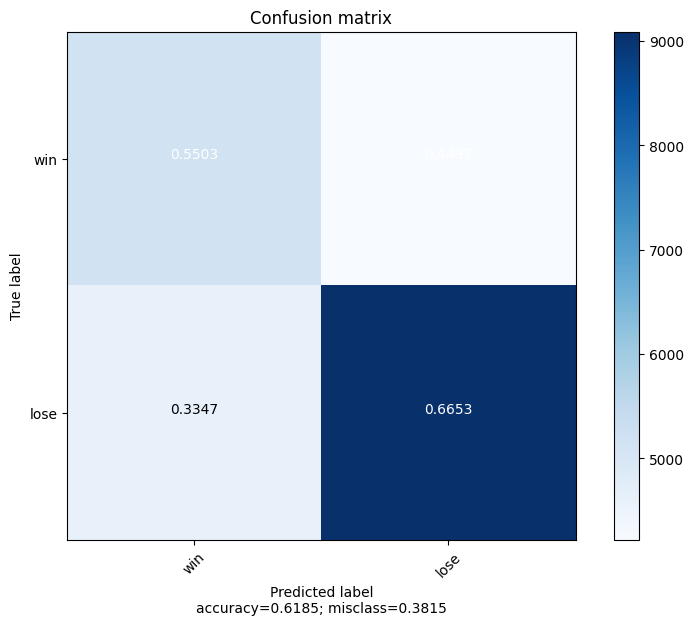

In [14]:
cm = confusion_matrix(target, train_oof_binary)
print(cm)
fig = plot_confusion_matrix(cm,['win','lose'])
run["evaluation/confusion_matrix"].upload(fig)


In [15]:
run["evaluation/classification_report"] = classification_report(target, train_oof_binary)
print(classification_report(target, train_oof_binary))

              precision    recall  f1-score   support

         0.0       0.53      0.55      0.54      9384
         1.0       0.68      0.67      0.67     13663

    accuracy                           0.62     23047
   macro avg       0.61      0.61      0.61     23047
weighted avg       0.62      0.62      0.62     23047



**Feature Importance via Weight - the number of times a feature appears in a tree**

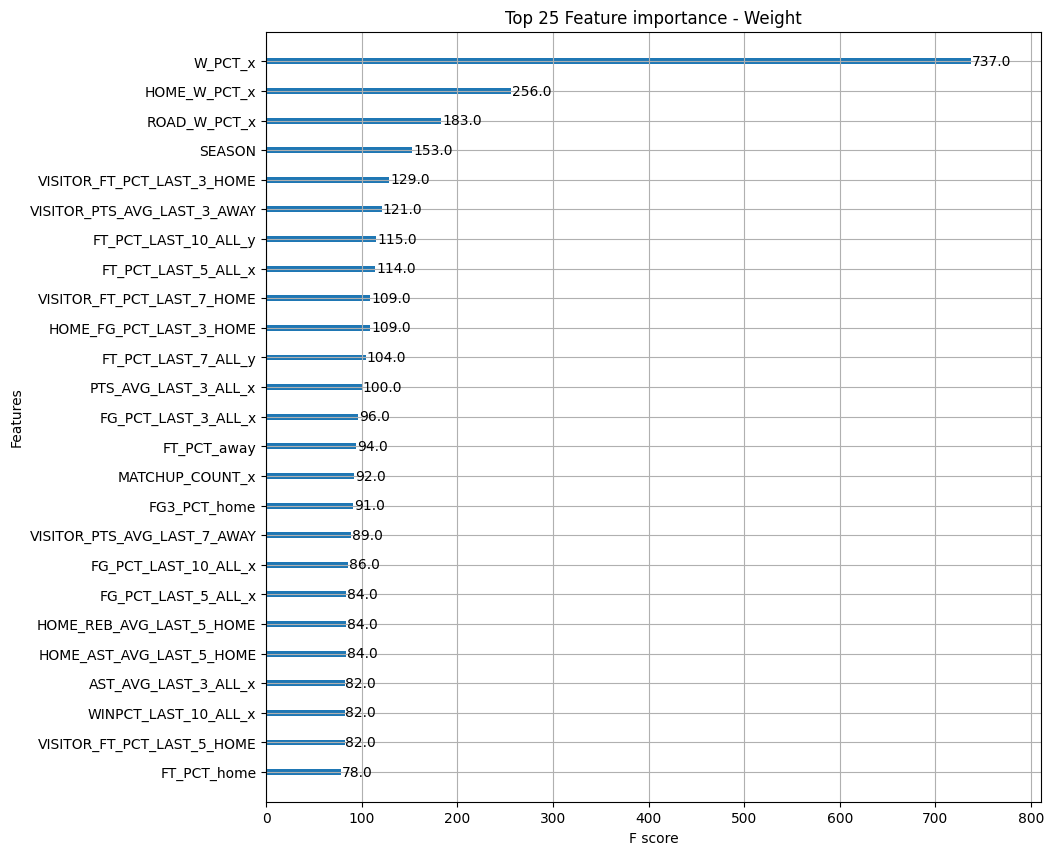

In [16]:
max_features = 25
max_title = 'Top ' + str(max_features) + ' Feature importance - Weight'
fig, ax = plt.subplots(1,1,figsize=(10,10))
xgb.plot_importance(model, importance_type='weight', max_num_features=max_features, title=max_title ,ax=ax)
run["evaluation/feature_importance_weight"].upload(fig)

**Feature Importance via Gain - the average gain of splits which use the feature**

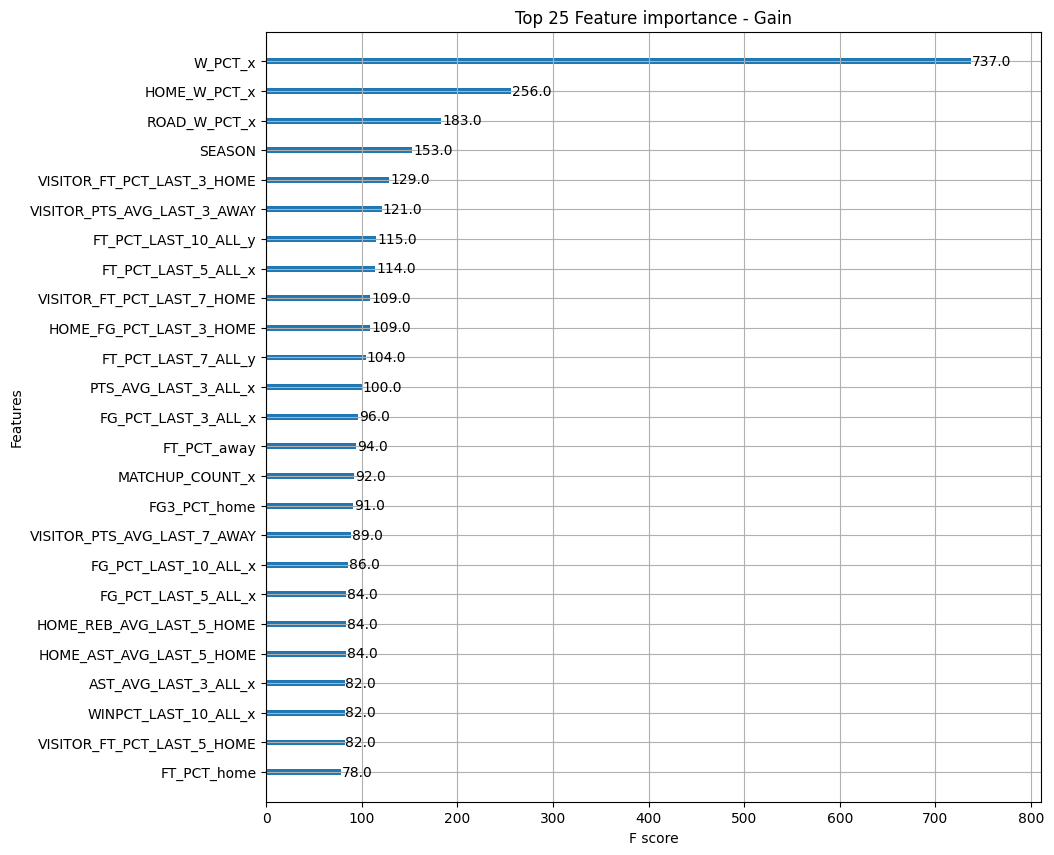

In [17]:
max_features = 25
max_title = 'Top ' + str(max_features) + ' Feature importance - Gain'
fig, ax = plt.subplots(1,1,figsize=(10,10))
xgb.plot_importance(model, importance_type='weight', max_num_features=max_features, title=max_title ,ax=ax)
run["evaluation/feature_importance_gain"].upload(fig)

**Feature Importance via Shapley values**

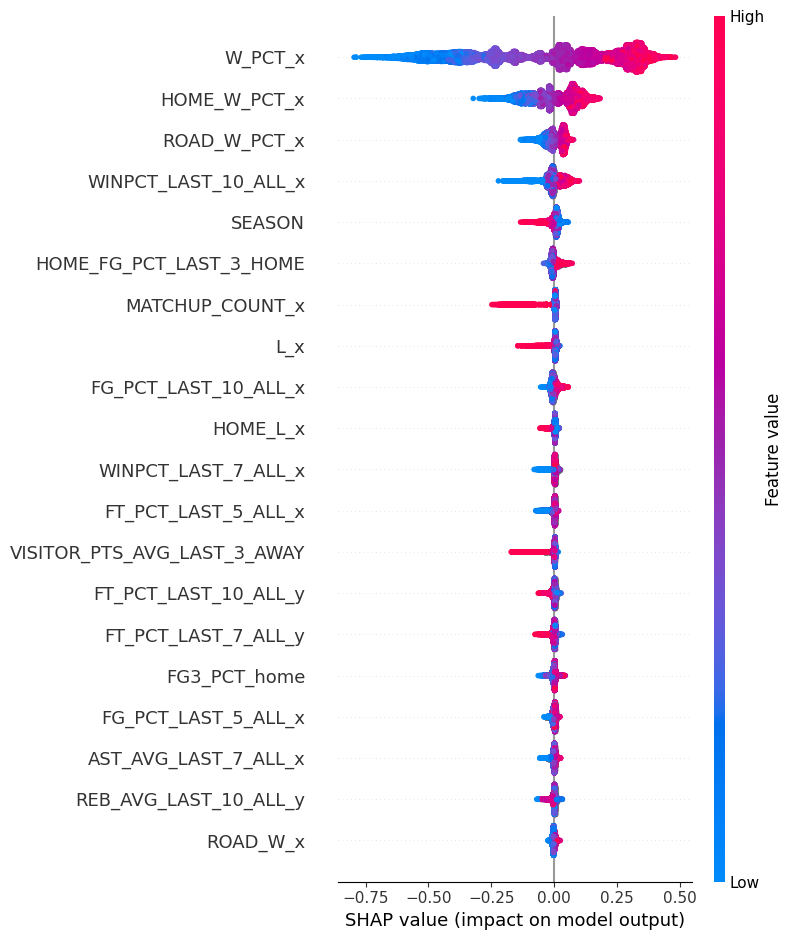

In [18]:
# summarize the effects of all the features
fig, ax = plt.subplots(1,1,figsize=(10,10))
shap.summary_plot(train_oof_shap[:,:-1], train)
run["evaluation/shapley_summary"].upload(fig)

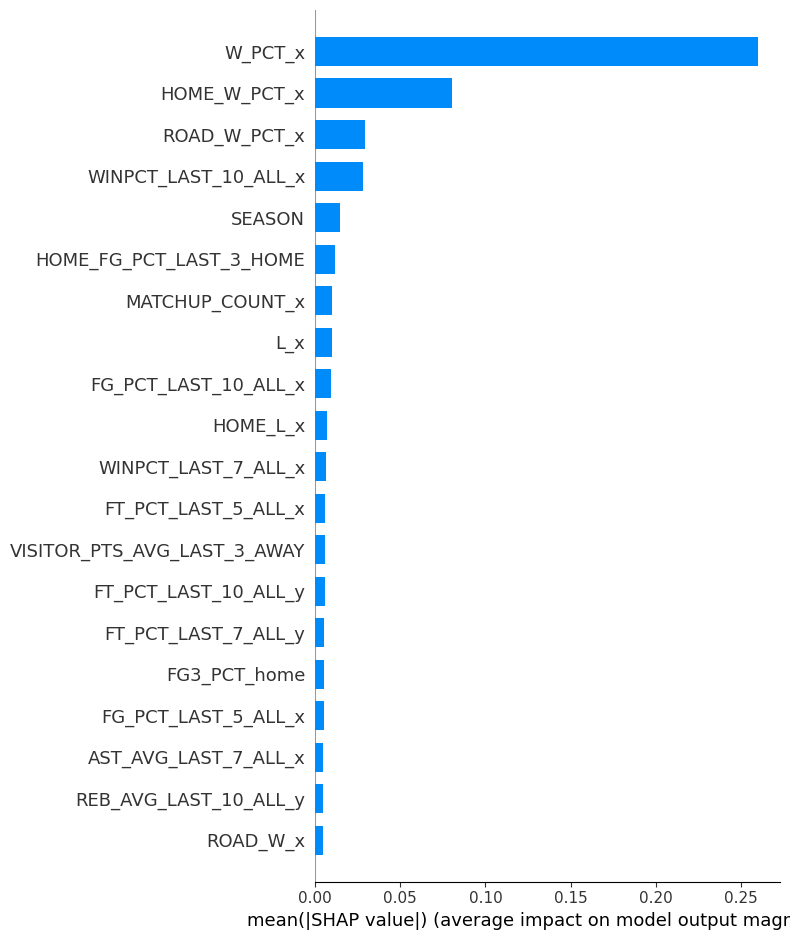

In [19]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
shap.summary_plot(train_oof_shap[:,:-1], train[use_columns], plot_type="bar")
run["evaluation/shapley_summary_bar"].upload(fig)

In [20]:
#end experiment tracking
run.stop()

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 125 operations to synchronize with Neptune. Do not kill this process.
All 125 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/cmunch1/nba-prediction/e/XGB-2
